# HANK-SAM

**Table of contents**<a id='toc0_'></a>    
- 1. [Steady state](#toc1_)    
  - 1.1. [Policy functions](#toc1_1_)    
  - 1.2. [Distribution](#toc1_2_)    
  - 1.3. [Spending in unemployment](#toc1_3_)    
- 2. [Effect of government spending](#toc2_)    
  - 2.1. [Tests](#toc2_1_)    
  - 2.2. [Jacobians](#toc2_2_)    
  - 2.3. [Response](#toc2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook shows how to **solve a Heterogenous Agent New Keynessian (HANK) model with a search-and-match (SAM) labor market** using the ``GEModelTools`` package.

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import scipy.optimize as optimize

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANKSAMModel import HANKSAMModelClass

In [2]:
def create_fig(figsize=(6,6/1.5)):
    
    fig = plt.figure(figsize=figsize,dpi=100)
    ax = fig.add_subplot(1,1,1)

    return fig,ax

def format_fig(fig,ax,ylabel='',T_max=48,legend=True):

    if legend: ax.legend(frameon=True)
    ax.set_xlabel('months')
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(T_max+1)[::12])
    ax.set_xlim([0,T_max]);
    
    fig.tight_layout()

## 1. <a id='toc1_'></a>[Steady state](#toc0_)

In [3]:
model = HANKSAMModelClass(name='baseline')

In [4]:
par = model.par
ss = model.ss
path = model.path

In [5]:
model.find_ss(do_print=True)

par.A = 0.3680
par.kappa = 1.8883
ss.w = 0.7500
ss.delta = 0.0200
ss.lambda_u_s = 0.3000
ss.lambda_v = 0.5000
ss.theta = 0.6000
ss.u = 0.0625
ss.S = 0.0625
household problem in ss solved in 18.1 secs [4082 iterations]
household problem in ss simulated in 6.9 secs [1959 iterations]
ss.G = 0.4226
ss.clearing_Y = 0.0000
par.jump_G = 0.0042
steady state found in 25.8 secs


In [6]:
try:
    model.test_ss()
except:
    print('newer version of GEModelTools needed')

w              :       0.7500
TFP            :       1.0000
px             :       0.8333
delta          :       0.0200
Vj             :       3.7766
errors_Vj      :       0.0000
v              :       0.0375
S              :       0.0625
u              :       0.0625
theta          :       0.6000
lambda_v       :       0.5000
lambda_u_s     :       0.3000
errors_u       :       0.0000
errors_Vv      :       0.0000
pi             :       0.0000
errors_pi      :       0.0000
i              :       0.0017
div            :       0.2344
q              :      33.9797
r              :       0.0017
G              :       0.4226
U_UI_hh_guess  :       0.0551
Phi            :       0.0312
transfer       :      -0.2344
X              :       0.2194
taut           :       0.3000
tau            :       0.3000
taxes          :       0.2203
B              :       0.0161
u_bar          :       6.0000
A_hh           :       0.5482
C_hh           :       0.5149
U_ALL_hh       :       0.0625
U_UI_hh   

### 1.1. <a id='toc1_1_'></a>[Policy functions](#toc0_)

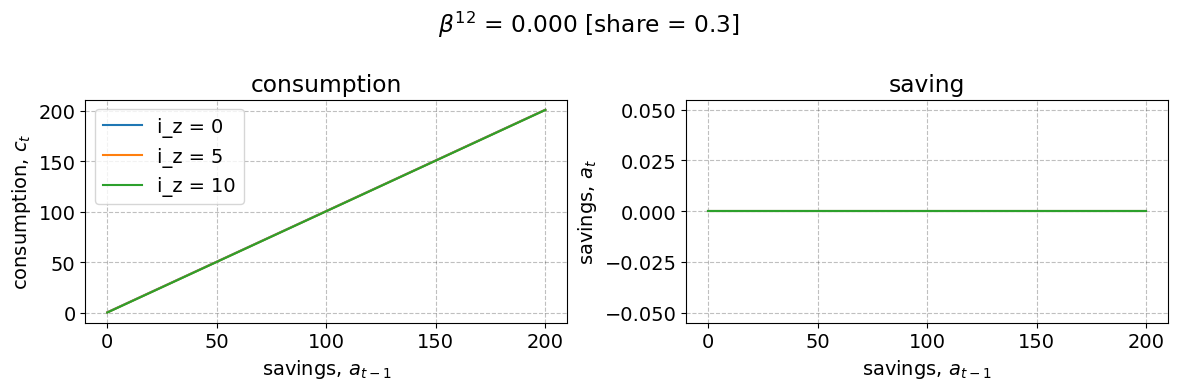

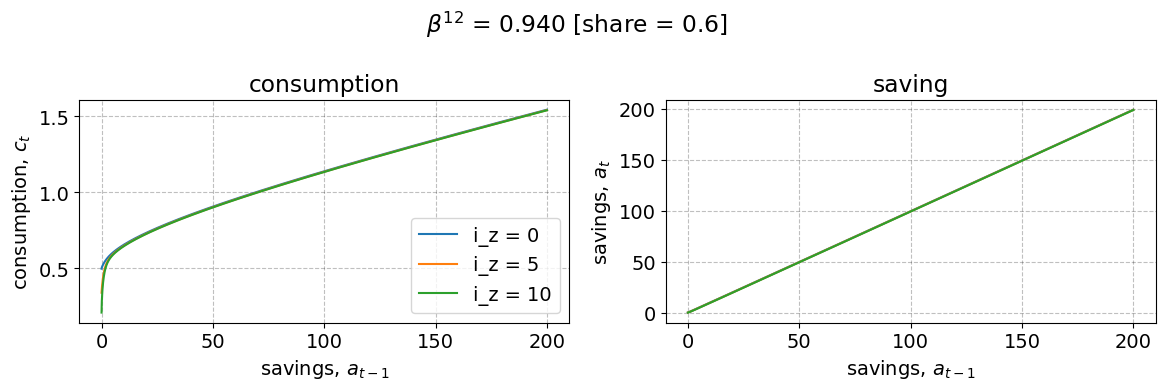

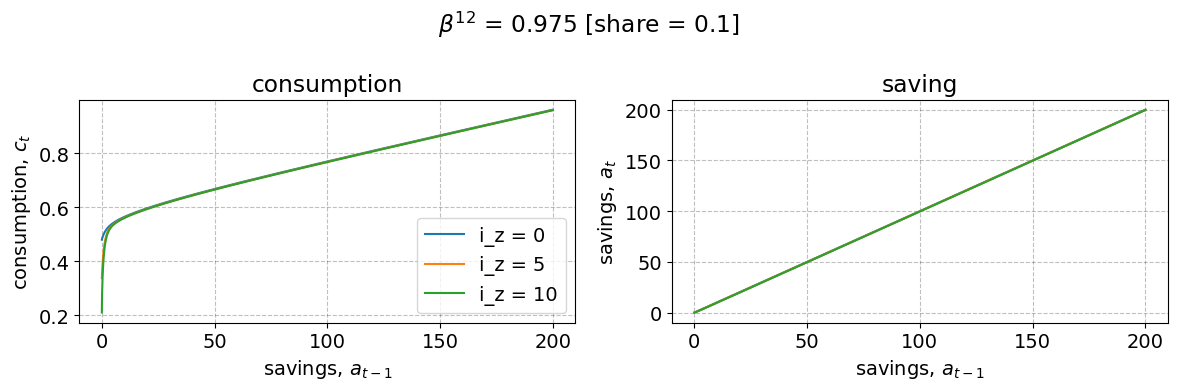

In [7]:
for i_fix in range(par.Nfix):

    fig = plt.figure(figsize=(12,4),dpi=100)
    a_max = 500

    # a. consumption
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')

    # b. saving
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings, $a_{t}$')

    fig.suptitle(fr'$\beta^{{12}}$ = {par.beta_grid[i_fix]**12:.3f} [share = {par.beta_shares[i_fix]}]')
    fig.tight_layout()

### 1.2. <a id='toc1_2_'></a>[Distribution](#toc0_)

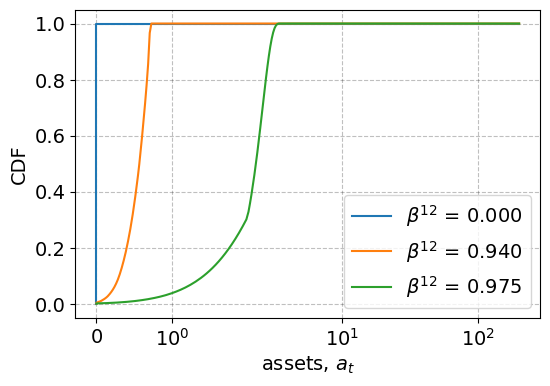

In [8]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)

for i_fix in range(par.Nfix):
    y = np.insert(np.cumsum(np.sum(ss.D[i_fix],axis=0)),0,0.0)
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1],
            label=f'$\\beta^{{12}}$ = {par.beta_grid[i_fix]**12:.3f}')
        
ax.legend(frameon=True)
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')


### 1.3. <a id='toc1_3_'></a>[Spending in unemployment](#toc0_)

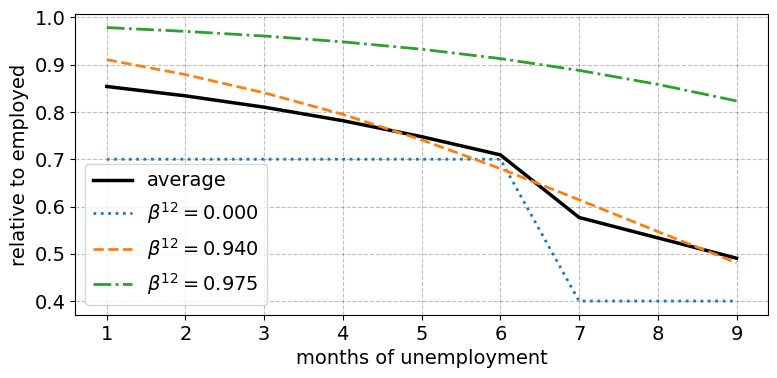

In [9]:
fig,ax = create_fig(figsize=(8,6/1.5))  

# baseline
C_e,C_u,C_u_dur = model.calc_Cs()
ax.plot(np.arange(1,par.Nu),C_u_dur[:-1]/C_e,ls='-',lw=2.5,color='black',label='average')

for i_fix,ls in zip(range(par.Nfix),[':','--','-.']):
    C_e,C_u,C_u_dur = model.calc_Cs(i_fix=i_fix)
    ax.plot(np.arange(1,par.Nu),C_u_dur[:-1]/C_e,lw=2,ls=ls,label=f'$\\beta^{{12}} = {par.beta_grid[i_fix]**12:.3f}$')

# details
ax.set_xticks(np.arange(1,par.Nu));
ax.set_xlabel('months of unemployment')
ax.set_ylabel('relative to employed')
ax.legend(frameon=True,ncol=1)

fig.tight_layout()

In [10]:
C_e,C_u,C_u_dur = model.calc_Cs()
C_drop_ss = (C_u/C_e-1)*100
C_drop_ex = (C_u_dur[6]-C_u_dur[5])/((1-ss.tau)*(par.phi_obar-par.phi_ubar)*ss.w)*100
print(f'{C_drop_ss = :.2f}')
print(f'{C_drop_ex = :.2f}')

C_drop_ss = -22.01
C_drop_ex = -43.90


## 2. <a id='toc2_'></a>[Effect of government spending](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Tests](#toc0_)

In [11]:
model.test_path()

shocks: G u_bar 
unknowns: px Vj v u S pi U_UI_hh_guess 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production
  w                0.0e+00
  TFP              0.0e+00
  delta            0.0e+00
  errors_Vj        0.0e+00 [target]
 blocks.labor_market
  theta            0.0e+00
  lambda_v         0.0e+00
  lambda_u_s       0.0e+00
  errors_u         0.0e+00 [target]
 blocks.entry
  errors_Vv        0.0e+00 [target]
 blocks.price_setters
  errors_pi        0.0e+00 [target]
 blocks.central_bank
  i                0.0e+00
 blocks.dividends
  div              0.0e+00
 blocks.financial_market
  q                0.0e+00
  r                2.2e-16
 blocks.government
  Phi              0.0e+00
  transfer         0.0e+00
  X                0.0e+00
  taut             0.0e+00
  tau              0.0e+00
  taxes            0.0e+00
  B                0.0e+00
 hh
  A_hh             7.9e-10
  C_hh             9.0e-12
  U_ALL_hh         1.3e-16
  U_UI_hh          1.2e-16
 blocks.market_cleari

### 2.2. <a id='toc2_2_'></a>[Jacobians](#toc0_)

In [12]:
model.compute_jacs(do_print=False,skip_shocks=True)

### 2.3. <a id='toc2_3_'></a>[Response](#toc0_)

In [13]:
model.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

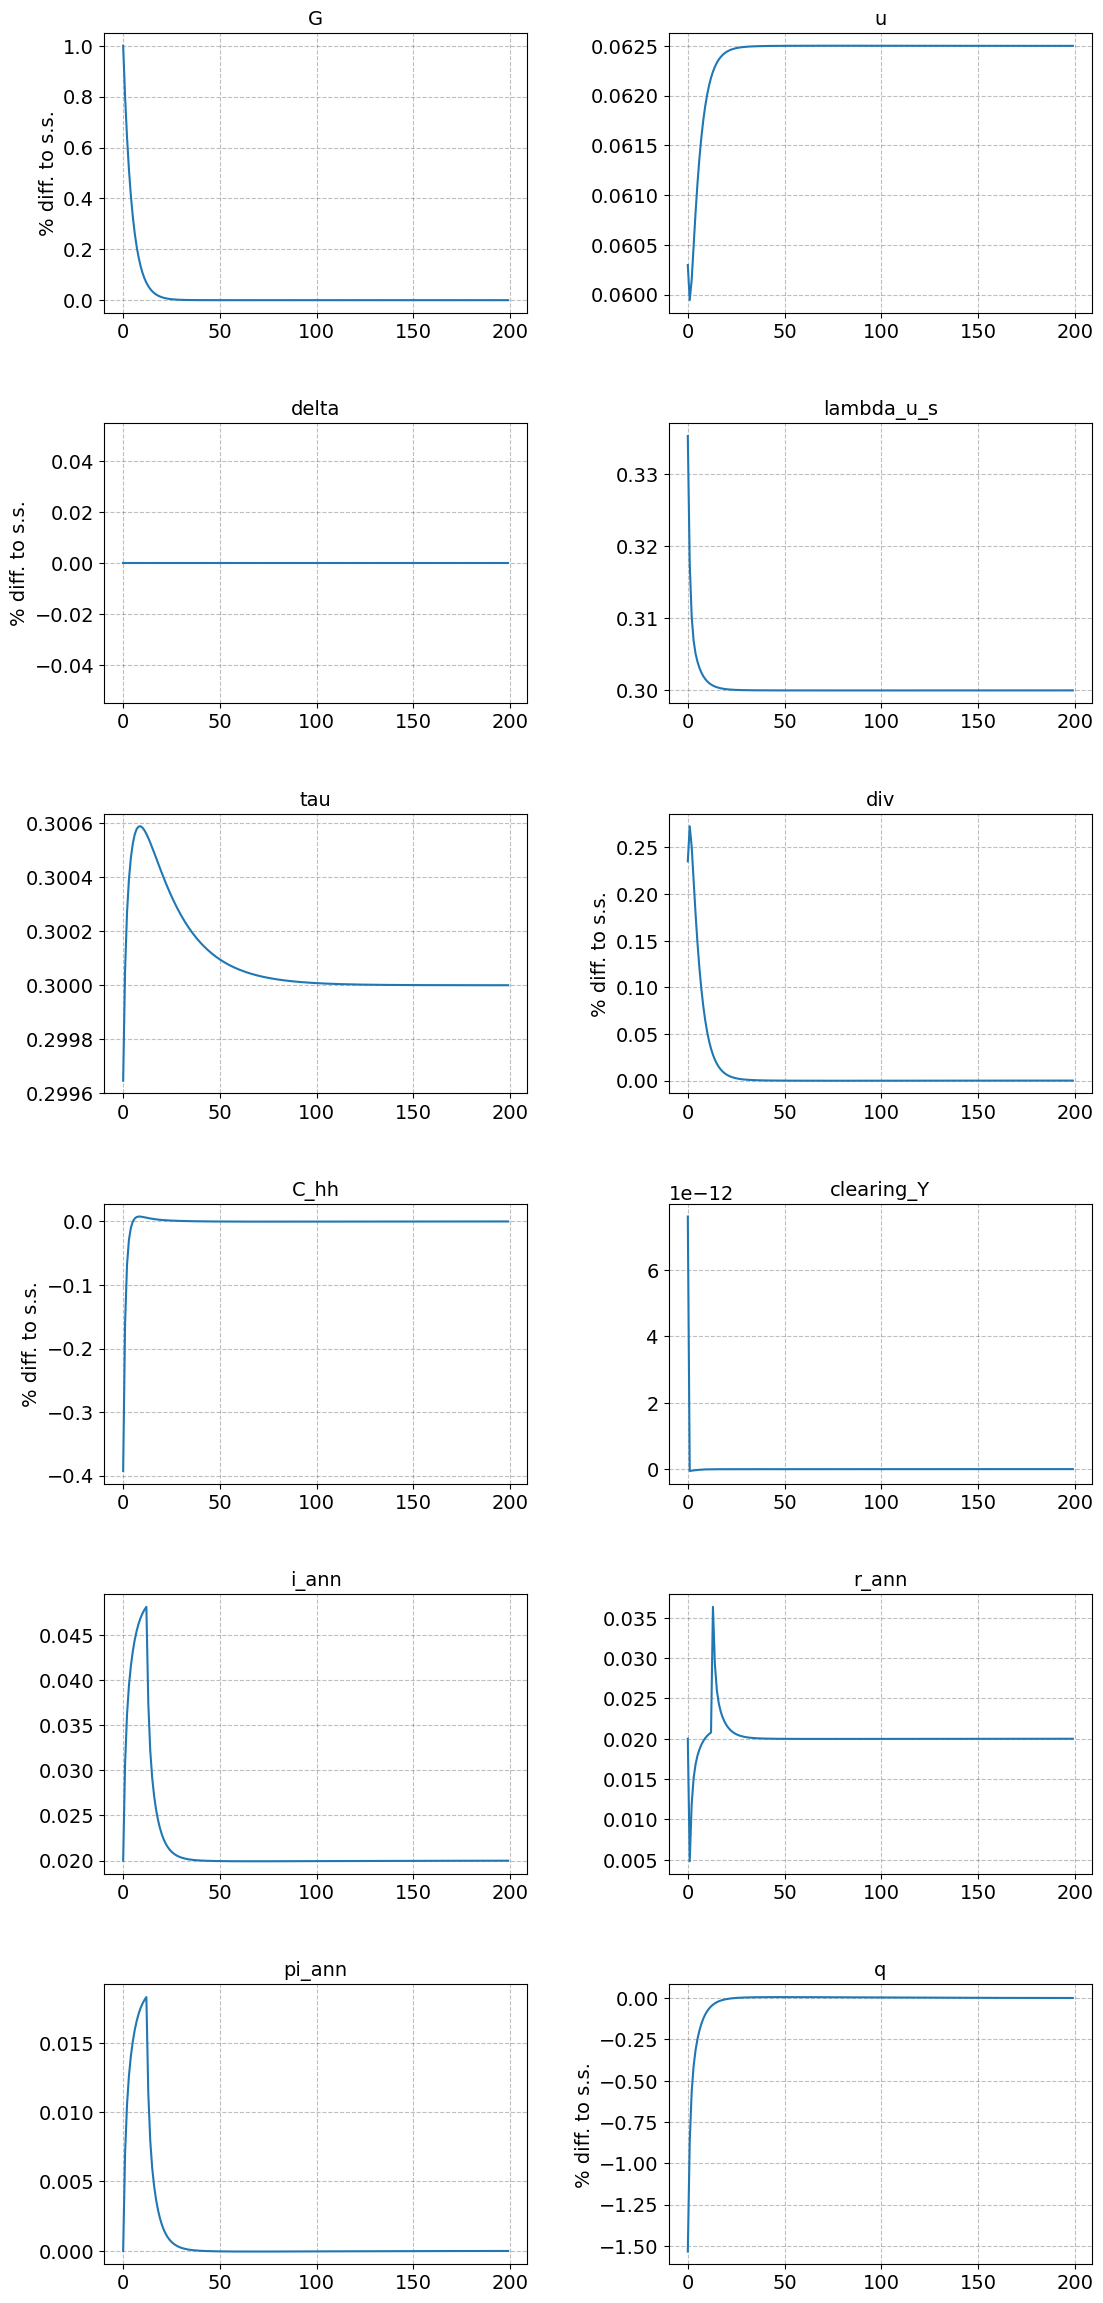

In [14]:
paths = ['G','u','delta','lambda_u_s','tau','div','C_hh','clearing_Y','i_ann','r_ann','pi_ann','q']
lvl_value = ['u','lambda_u_s','tau','i_ann','r_ann','pi_ann','clearing_Y']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=200,ncols=2,do_shocks=False,do_targets=False)

### 1.C

In [15]:
model.find_IRFs(shocks=['G'],do_print=True)

linear transition path found in 0.8 secs [finding solution matrix: 0.8 secs]


### shocks ###


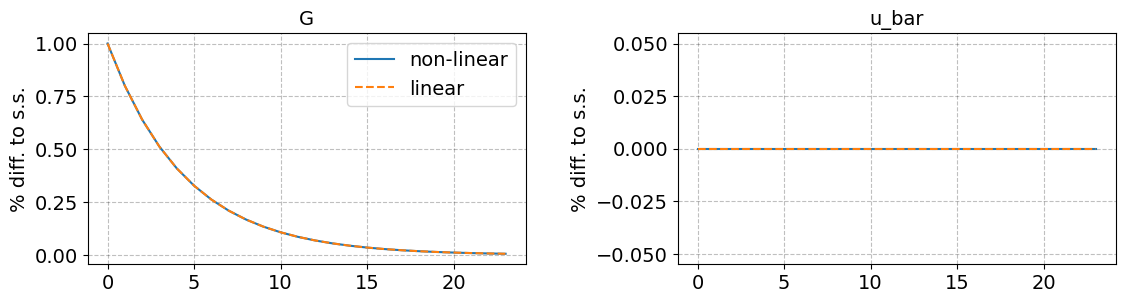


### varnames ###


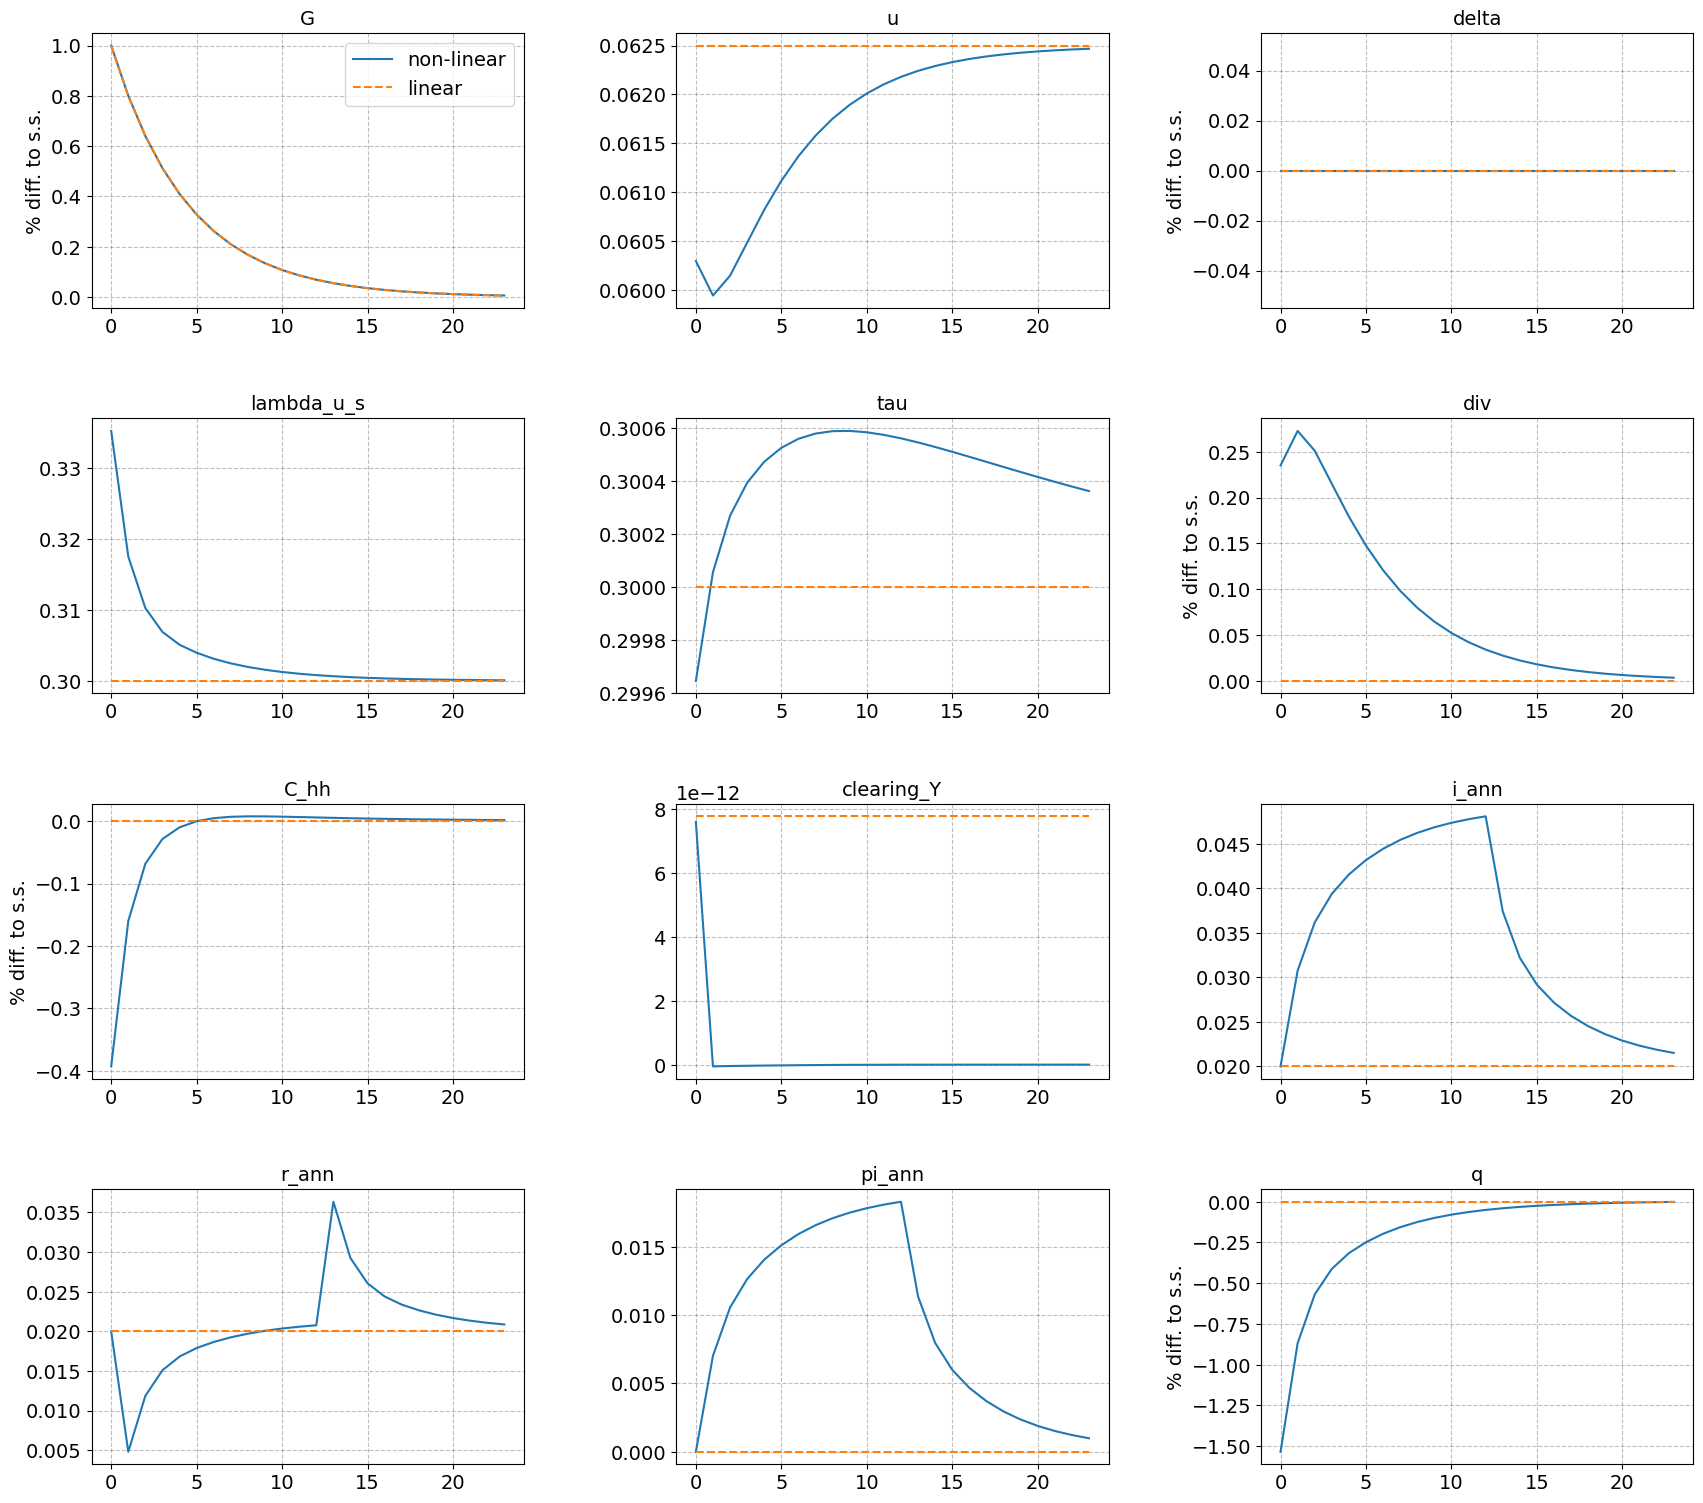


### tagets ###


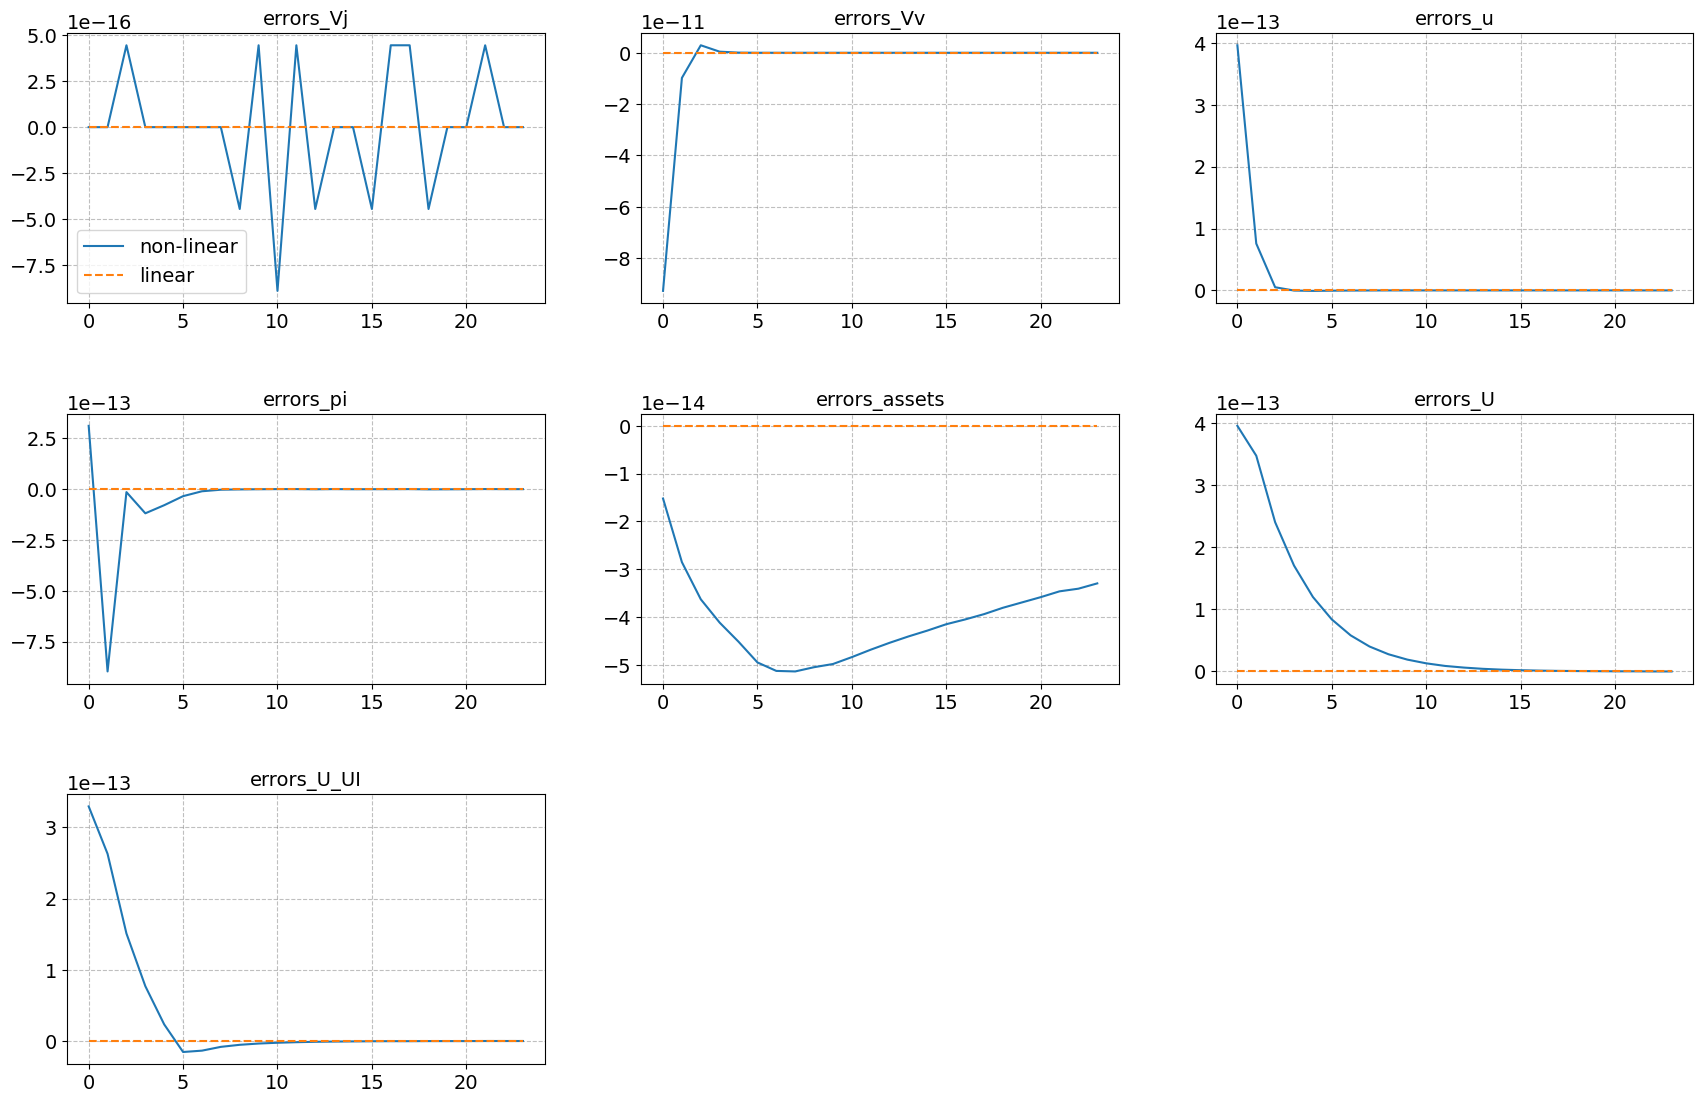

In [16]:
model.show_IRFs(paths,lvl_value=lvl_value,T_max=24,ncols=3,do_linear=True)

### 2.a

In [17]:
def test_size(parname,values,find_ss=False,skip_hh=False):

    for value in values:

        try:

            print(f'{parname} = {value:.2f}')
            model_ = model.copy()
            model_.par.__dict__[parname] = value
            if find_ss: model_.find_ss()
            model_.compute_jacs(skip_hh=skip_hh)
            model_.find_transition_path(shocks=['G'],do_print=False)
            model_.calc_fiscal_multiplier()
            print('')

        except Exception as e:
            
            print(f'could not solve, {e}')    

In [18]:
test_size('omega',[0.05,0.10,0.20],skip_hh=True)

omega = 0.05
pi: terminal value is  -0.00000002, but ss value is   0.00000000
i: terminal value is   0.00165155, but ss value is   0.00165158
i_ann: terminal value is   0.01999969, but ss value is   0.02000000
pi_ann: terminal value is  -0.00000020, but ss value is   0.00000000
fiscal_multiplier = 1.271

omega = 0.10
pi_ann: terminal value is  -0.00000008, but ss value is   0.00000000
fiscal_multiplier = 1.120

omega = 0.20
pi_ann: terminal value is  -0.00000006, but ss value is   0.00000000
fiscal_multiplier = 1.005



In [19]:
def test_size_more(parname,values):   
    for value in values:
        for i_beta,beta in enumerate(par.beta_grid[:]):
            print(f'{i_beta} = {beta:.5f}')
            model1 = HANKSAMModelClass(name='baseline')
            model1.find_ss(do_print=False)
            model1.compute_jacs(skip_hh=False)
            model1.find_transition_path(shocks=[],do_print=False)
            model_ = model1.copy()
            model_.par.__dict__[parname] = value
            model_.compute_jacs(skip_hh=False)
            model_.find_transition_path(shocks=['G'],do_print=False)
            consumption_no_shock = np.sum(model1.path.D[i_beta,:,:]*model1.path.c[i_beta,:,:])/np.sum(model1.path.D[i_beta,:,:])
            consumption_shock = np.sum(model_.path.D[i_beta,:,:]*model_.path.c[i_beta,:,:])/np.sum(model_.path.D[i_beta,:,:])
            print(f'for beta = {par.beta_grid[i_fix]:.4f} : no shock c= {consumption_no_shock:.4f}, consumption when shock = {consumption_shock:.4f}: change = {consumption_shock-consumption_no_shock:.5f}')
            print('')

In [20]:
test_size_more('omega',[0.05,0.10,0.20])

0 = 0.00000
pi: terminal value is  -0.00000002, but ss value is   0.00000000
i: terminal value is   0.00165155, but ss value is   0.00165158
i_ann: terminal value is   0.01999969, but ss value is   0.02000000
pi_ann: terminal value is  -0.00000020, but ss value is   0.00000000
for beta = 0.9979 : no shock c= 0.5149, consumption when shock = 0.5129: change = -0.00202

1 = 0.99486
pi: terminal value is  -0.00000002, but ss value is   0.00000000
i: terminal value is   0.00165155, but ss value is   0.00165158
i_ann: terminal value is   0.01999969, but ss value is   0.02000000
pi_ann: terminal value is  -0.00000020, but ss value is   0.00000000
for beta = 0.9979 : no shock c= 0.5149, consumption when shock = 0.5141: change = -0.00082

2 = 0.99789
pi: terminal value is  -0.00000002, but ss value is   0.00000000
i: terminal value is   0.00165155, but ss value is   0.00165158
i_ann: terminal value is   0.01999969, but ss value is   0.02000000
pi_ann: terminal value is  -0.00000020, but ss valu

# comparing IRF's

In [21]:
model2 = HANKSAMModelClass(name='baseline')
model2.find_ss(do_print=False)
model2.compute_jacs(skip_hh=False)
model2.find_transition_path(shocks=['G'],do_print=False)

model2_ = HANKSAMModelClass(name='alt')
model2_.par.omega = 0.1
model2_.find_ss(do_print=False)
model2_.compute_jacs(skip_hh=False)
model2_.find_transition_path(shocks=['G'],do_print=False)

pi: terminal value is  -0.00000002, but ss value is   0.00000000
i: terminal value is   0.00165155, but ss value is   0.00165158
i_ann: terminal value is   0.01999969, but ss value is   0.02000000
pi_ann: terminal value is  -0.00000020, but ss value is   0.00000000
pi_ann: terminal value is  -0.00000008, but ss value is   0.00000000


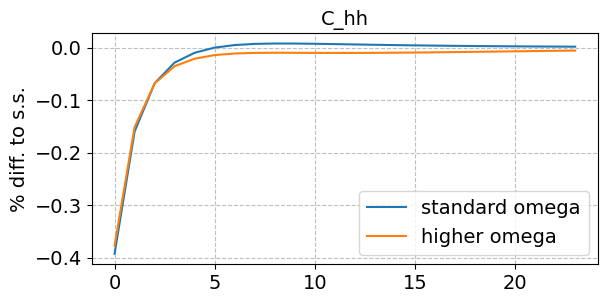

In [22]:
model.compare_IRFs([model2,model2_],['standard omega','higher omega'],varnames=['C_hh'],T_max=24,do_shocks=False,do_targets=False)

### Question 2.c

pi: terminal value is  -0.00000002, but ss value is   0.00000000
i: terminal value is   0.00165155, but ss value is   0.00165158
i_ann: terminal value is   0.01999969, but ss value is   0.02000000
pi_ann: terminal value is  -0.00000020, but ss value is   0.00000000
pi: terminal value is  -0.00000001, but ss value is   0.00000000
pi_ann: terminal value is  -0.00000011, but ss value is   0.00000000


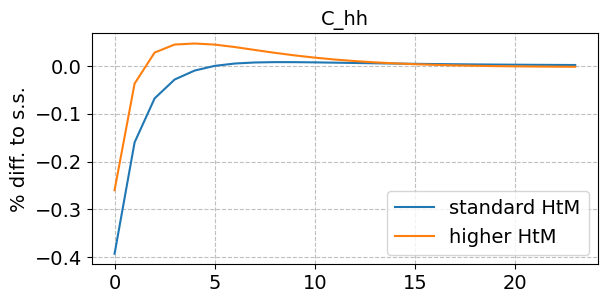

In [23]:
model3 = HANKSAMModelClass(name='baseline')
model3.find_ss(do_print=False)
model3.compute_jacs(skip_hh=False)
model3.find_transition_path(shocks=['G'],do_print=False)

model3_ = HANKSAMModelClass(name='alt')
model3_.par.HtM_share = 0.5
model3_.find_ss(do_print=False)
model3_.compute_jacs(skip_hh=False)
model3_.find_transition_path(shocks=['G'],do_print=False)

model.compare_IRFs([model3,model3_],['standard HtM','higher HtM'],varnames=['C_hh'],T_max=24,do_shocks=False,do_targets=False)

In [24]:
model3_.calc_fiscal_multiplier()

fiscal_multiplier = 1.615


### Question 2.d

In [25]:
from HANKSAMModel import RANKModelClass

In [26]:
model_RA = RANKModelClass(name='RA')
model_RA.find_ss()
model_RA.test_path()

shocks: G u_bar 
unknowns: px Vj v u S pi U_UI_hh_guess 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production
  w                0.0e+00
  TFP              0.0e+00
  delta            0.0e+00
  errors_Vj        0.0e+00 [target]
 blocks.labor_market
  theta            0.0e+00
  lambda_v         0.0e+00
  lambda_u_s       0.0e+00
  errors_u         0.0e+00 [target]
 blocks.entry
  errors_Vv        0.0e+00 [target]
 blocks.price_setters
  errors_pi        0.0e+00 [target]
 blocks.central_bank
  i                0.0e+00
 blocks.dividends
  div              0.0e+00
 blocks.financial_market
  q                0.0e+00
  r                2.2e-16
 blocks.government
  Phi              0.0e+00
  transfer         0.0e+00
  X                0.0e+00
  taut             0.0e+00
  tau              0.0e+00
  taxes            0.0e+00
  B                0.0e+00
 hh
  A_hh             7.9e-10
  C_hh             9.0e-12
  U_ALL_hh         1.3e-16
  U_UI_hh          1.2e-16
 blocks.market_cleari

In [27]:
model_RA.test_ss()

w              :       0.7500
TFP            :       1.0000
px             :       0.8333
delta          :       0.0200
Vj             :       3.7766
errors_Vj      :       0.0000
v              :       0.0375
S              :       0.0625
u              :       0.0625
theta          :       0.6000
lambda_v       :       0.5000
lambda_u_s     :       0.3000
errors_u       :       0.0000
errors_Vv      :       0.0000
pi             :       0.0000
errors_pi      :       0.0000
i              :       0.0017
div            :       0.2344
q              :      33.9797
r              :       0.0017
G              :       0.4226
U_UI_hh_guess  :       0.0551
Phi            :       0.0312
transfer       :      -0.2344
X              :       0.2194
taut           :       0.3000
tau            :       0.3000
taxes          :       0.2203
B              :       0.0161
u_bar          :       6.0000
A_hh           :       0.5482
C_hh           :       0.5149
U_ALL_hh       :       0.0625
U_UI_hh   

In [28]:
model_RA.compute_jacs(do_print=False)

In [29]:
model_RA.find_transition_path(shocks=['G'],do_print=False)

A_hh: terminal value is   0.54818743, but ss value is   0.54820753


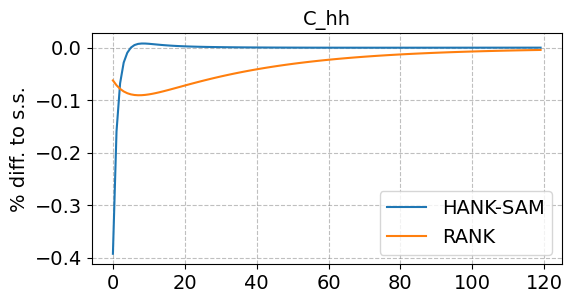

In [30]:
model_RA.compare_IRFs([model,model_RA],['HANK-SAM','RANK'],['C_hh'],do_shocks=False,do_targets=False,ncols=2,T_max=120)

A_hh: terminal value is   0.72430975, but ss value is   0.72433384


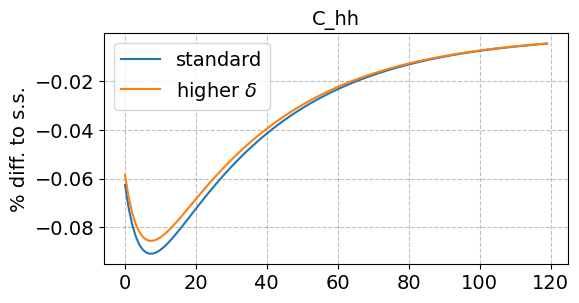

In [31]:
model_RA1 = RANKModelClass(name='alt')
model_RA1.par.delta_ss = 0.030
model_RA1.find_ss()
model_RA1.compute_jacs(do_print=False)
model_RA1.find_transition_path(shocks=['G'],do_print=False)

model_RA.compare_IRFs([model_RA,model_RA1],['standard','higher $\delta$'],['C_hh'],do_shocks=False,do_targets=False,ncols=2,T_max=120)

### Question 3.a

In [32]:
# Here i'm testing that i'm getting the same results as before, expecting to get a multiplier of 1.271, i'm doing this since i changed the code, and i want to make sure i'm getting the same results as before
model_test1 = HANKSAMModelClass(name='test')
model_test1.par.u_bar_ss=6.0
model_test1.find_ss()
model_test1.compute_jacs()
model_test1.find_transition_path(shocks=['G'],do_print=False)
model_test1.calc_fiscal_multiplier()

pi: terminal value is  -0.00000002, but ss value is   0.00000000
i: terminal value is   0.00165155, but ss value is   0.00165158
i_ann: terminal value is   0.01999969, but ss value is   0.02000000
pi_ann: terminal value is  -0.00000020, but ss value is   0.00000000
fiscal_multiplier = 1.271


In [45]:
model4 = HANKSAMModelClass(name='test')
model4.par.u_bar_ss=7.0 # permanent increase in unemployment benefit duration
model4.find_ss()
model4.compute_jacs()
model4.find_transition_path(shocks=[],do_print=False)
model4.calc_fiscal_multiplier()

fiscal_multiplier = 0.503


### Question 3.b

In [34]:
model5 = HANKSAMModelClass(name='test')
model5.find_ss()
model5.compute_jacs()

In [35]:
ini = {}
for varname in model5.varlist:
    ini[varname] = model5.ss.__dict__[varname]
    ini['Dbeg'] = model5.ss.Dbeg

In [36]:
# find transition path
du_bar = np.zeros(par.T)
du_bar[:12] = 1 # increase in unemployment benefit duration for 12 months
shocks = {'du_bar':du_bar} 

model5.find_transition_path(do_print=True,shocks=shocks,ini=ini)

finding the transition path:
 it =   0 -> max. abs. error = 2.36e-03
   0.00e+00 in errors_Vj
   0.00e+00 in errors_Vv
   0.00e+00 in errors_u
   0.00e+00 in errors_pi
   2.36e-03 in errors_assets
   1.40e-15 in errors_U
   2.21e-03 in errors_U_UI
 it =   1 -> max. abs. error = 7.51e-04
   2.64e-13 in errors_Vj
   7.51e-04 in errors_Vv
   8.88e-06 in errors_u
   7.33e-04 in errors_pi
   2.89e-05 in errors_assets
   9.48e-06 in errors_U
   7.39e-05 in errors_U_UI
 it =   2 -> max. abs. error = 3.11e-05
   1.78e-15 in errors_Vj
   3.11e-05 in errors_Vv
   4.65e-08 in errors_u
   1.56e-05 in errors_pi
   1.67e-07 in errors_assets
   4.59e-08 in errors_U
   2.28e-07 in errors_U_UI
 it =   3 -> max. abs. error = 1.27e-06
   8.88e-16 in errors_Vj
   1.27e-06 in errors_Vv
   4.78e-09 in errors_u
   5.66e-08 in errors_pi
   6.72e-09 in errors_assets
   4.78e-09 in errors_U
   1.70e-08 in errors_U_UI
 it =   4 -> max. abs. error = 5.60e-09
   8.88e-16 in errors_Vj
   5.60e-09 in errors_Vv
   4.

### shocks ###


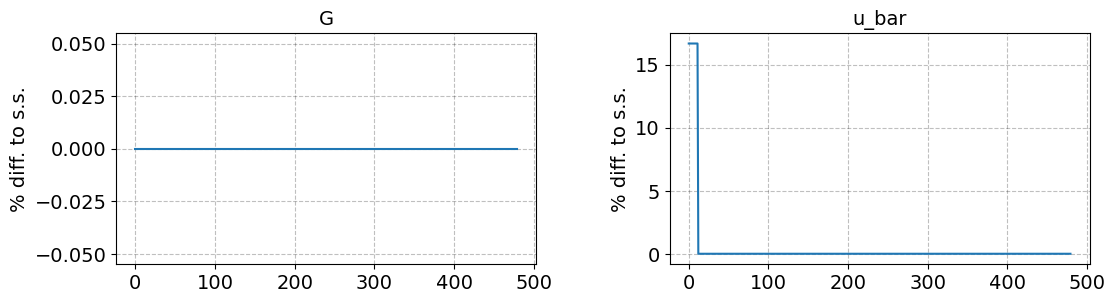


### varnames ###


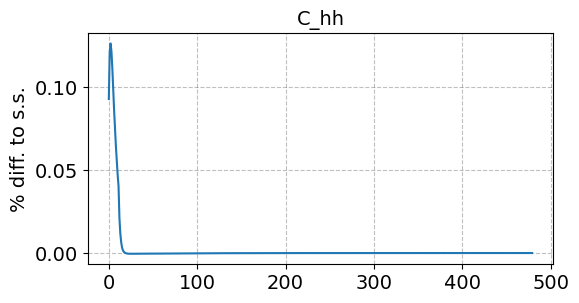


### tagets ###


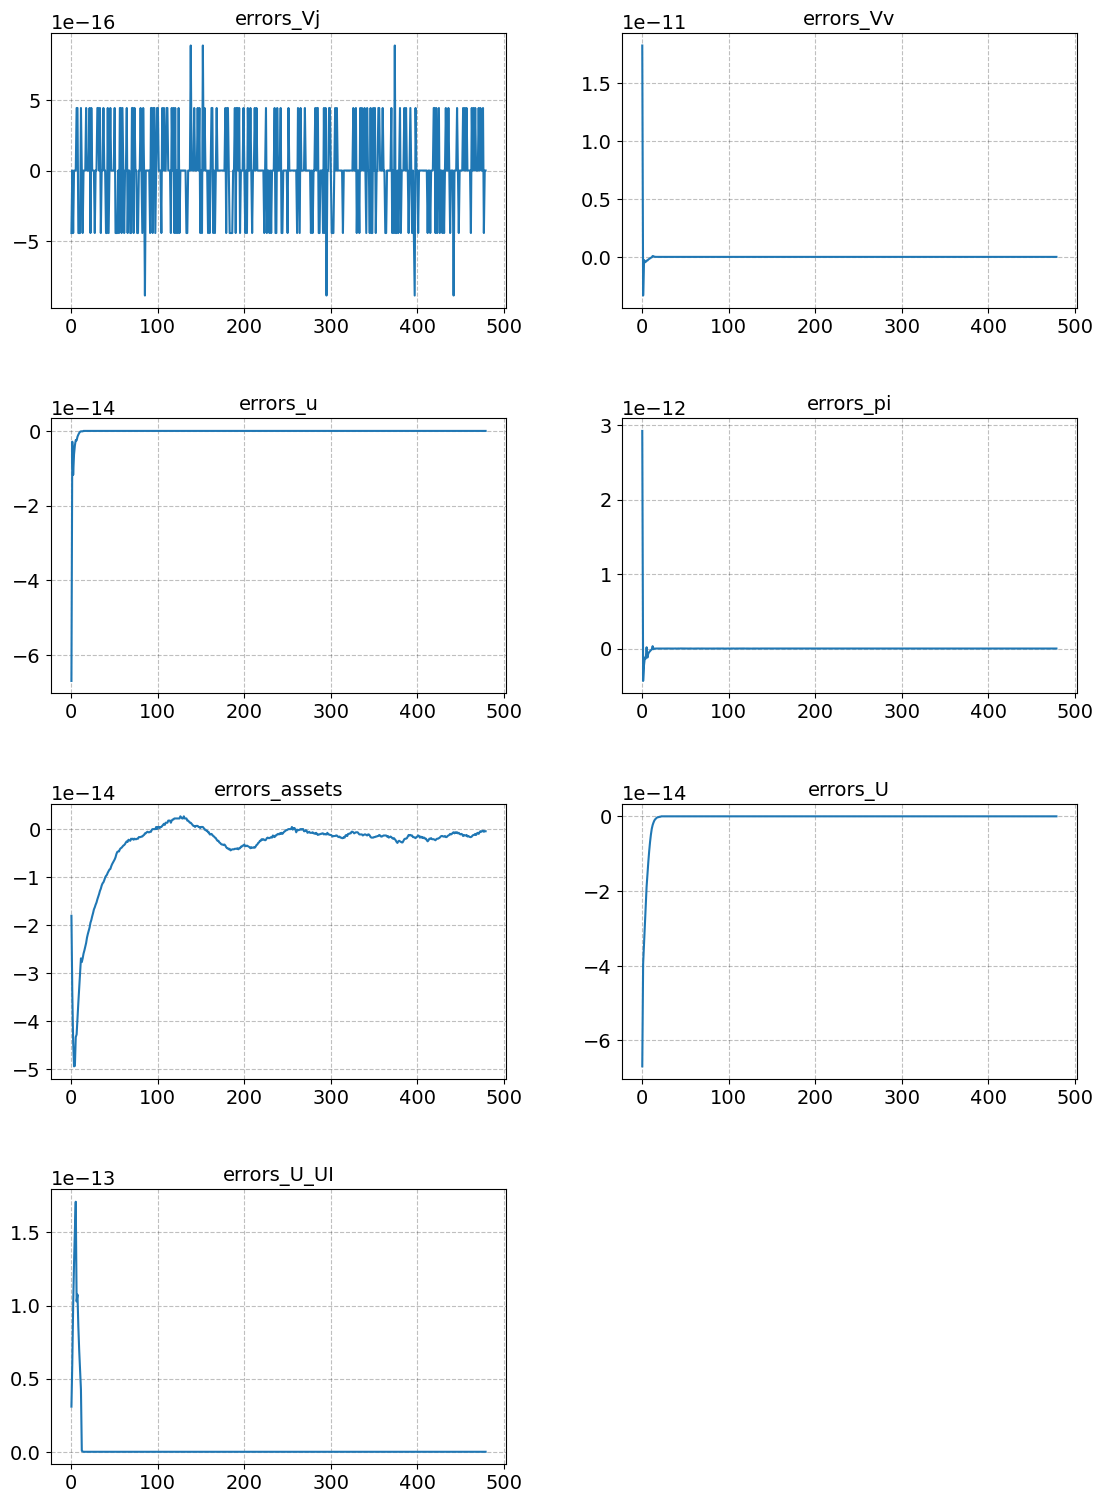

In [37]:
model5.show_IRFs(varnames=['C_hh'],ncols=2)

In [38]:
model5.calc_fiscal_multiplier()

fiscal_multiplier = 1.480


### Question 3.c

In [39]:
model6 = HANKSAMModelClass(name='test')
model6.find_ss()
model6.compute_jacs()

In [40]:
ini = {}
for varname in model6.varlist:
    ini[varname] = model6.ss.__dict__[varname]
    ini['Dbeg'] = model6.ss.Dbeg

In [41]:
# find transition path
du_bar = np.zeros(par.T)
du_bar[12:24] = 1 # increase in unemployment benefit duration for 12 months
shocks = {'du_bar':du_bar} 

model6.find_transition_path(do_print=True,shocks=shocks,ini=ini)

finding the transition path:
 it =   0 -> max. abs. error = 9.54e-03
   0.00e+00 in errors_Vj
   0.00e+00 in errors_Vv
   0.00e+00 in errors_u
   0.00e+00 in errors_pi
   9.54e-03 in errors_assets
   1.39e-15 in errors_U
   2.21e-03 in errors_U_UI
 it =   1 -> max. abs. error = 2.40e-04
   9.95e-14 in errors_Vj
   2.17e-04 in errors_Vv
   2.55e-06 in errors_u
   1.69e-04 in errors_pi
   2.40e-04 in errors_assets
   5.45e-06 in errors_U
   6.35e-05 in errors_U_UI
 it =   2 -> max. abs. error = 5.34e-06
   2.22e-15 in errors_Vj
   5.34e-06 in errors_Vv
   7.06e-08 in errors_u
   3.93e-06 in errors_pi
   8.69e-07 in errors_assets
   1.51e-07 in errors_U
   2.56e-07 in errors_U_UI
 it =   3 -> max. abs. error = 1.91e-07
   8.88e-16 in errors_Vj
   7.29e-08 in errors_Vv
   1.11e-09 in errors_u
   1.91e-07 in errors_pi
   2.86e-08 in errors_assets
   1.53e-09 in errors_U
   1.03e-08 in errors_U_UI
 it =   4 -> max. abs. error = 1.57e-09
   8.88e-16 in errors_Vj
   8.27e-10 in errors_Vv
   1.

### shocks ###


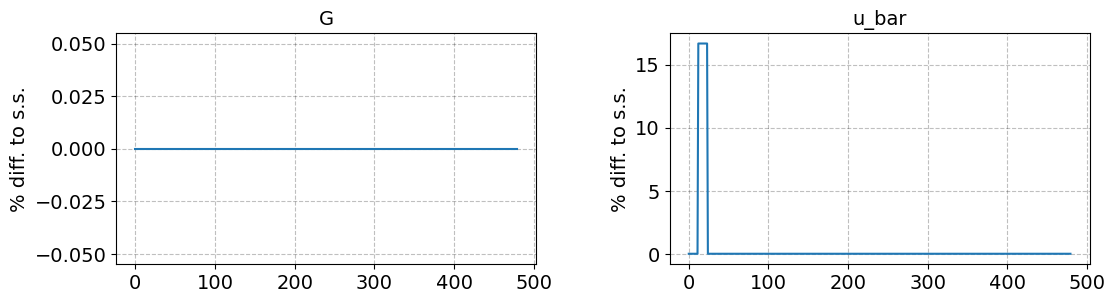


### varnames ###


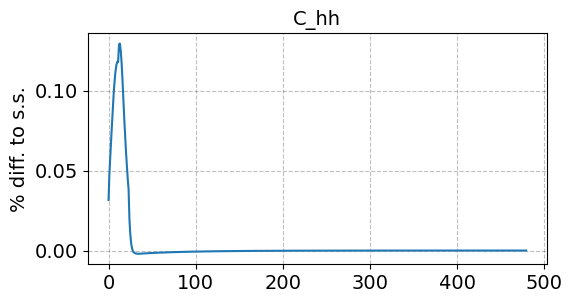


### tagets ###


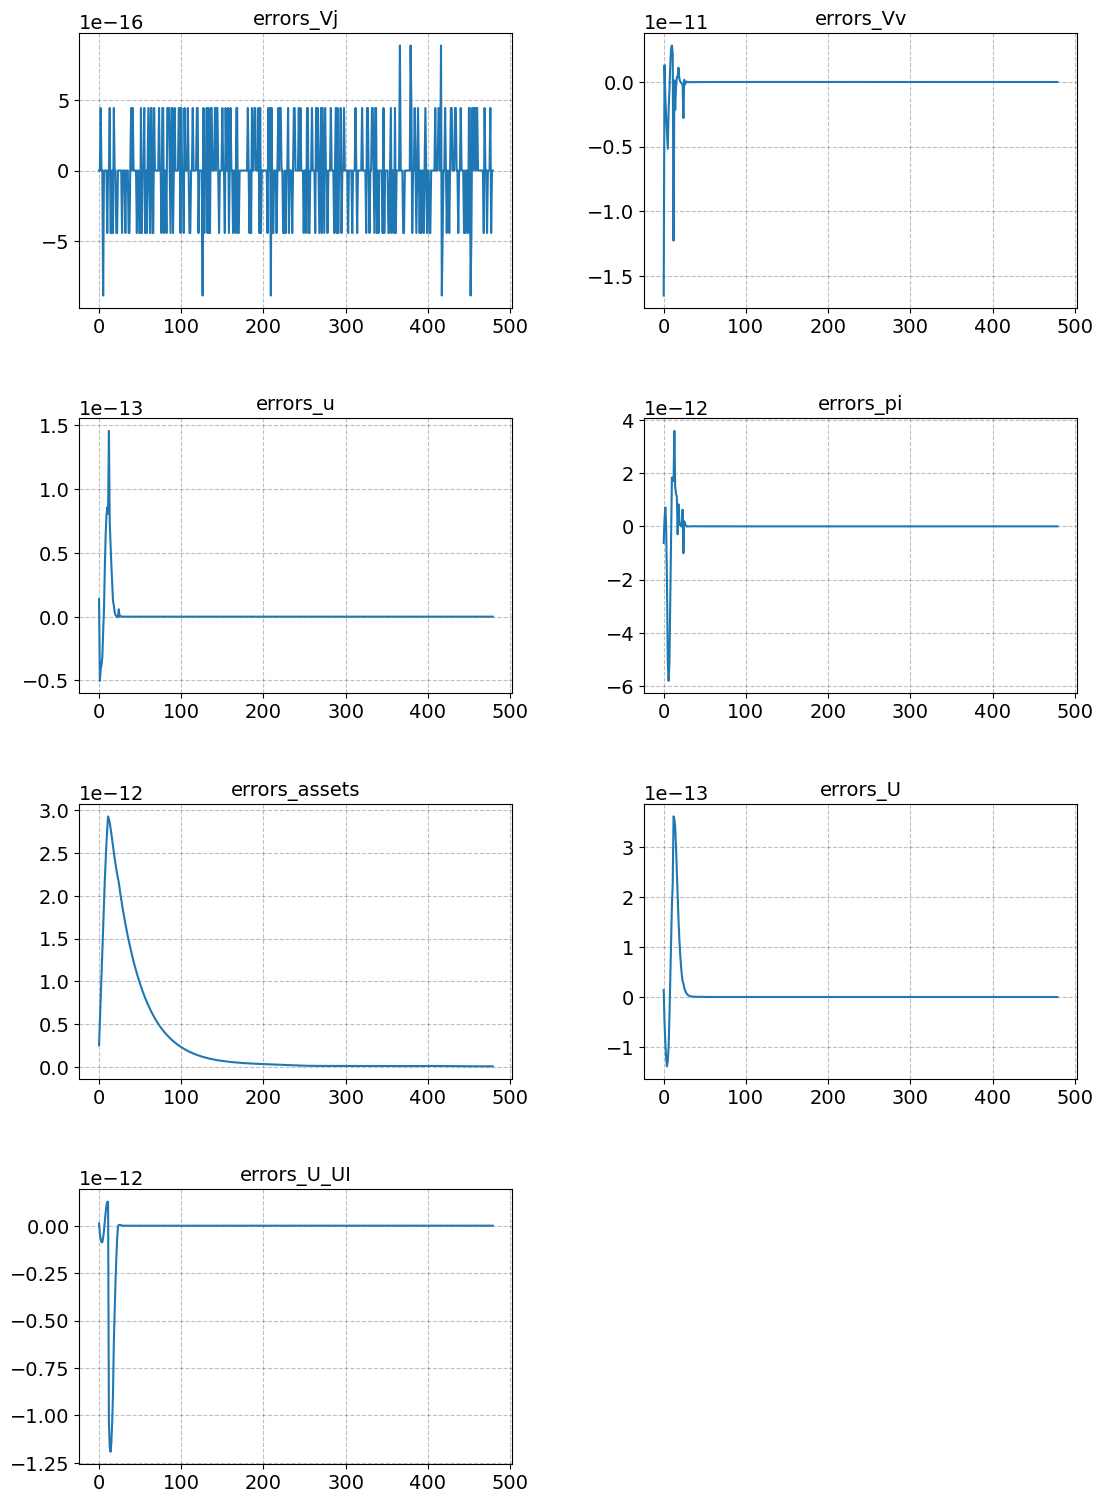

In [42]:
model6.show_IRFs(varnames=['C_hh'],ncols=2)

In [43]:
model6.calc_fiscal_multiplier()

fiscal_multiplier = 5.186


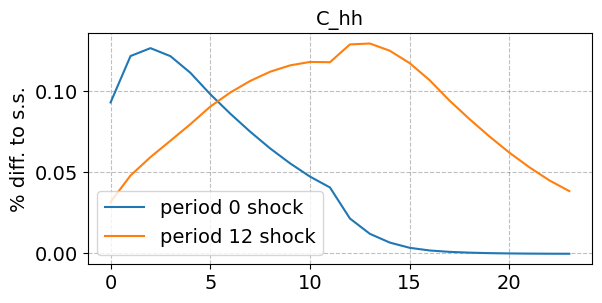

In [44]:
model6.compare_IRFs([model5,model6],['period 0 shock','period 12 shock'],T_max=24,varnames=['C_hh'],do_shocks=False,do_targets=False)

### Question 3.d